# Music Genre Classification using multiple classifiers
Team Members: Lisa Korntheuer, Jan Birkert, Adrian Desiderato, Jan Wangerin, Spyridon Spyropoulos

Music offers a variety of genres, ranging from classical compositions to modern pieces such as jazz songs, rock and pop hits. Although they might overlap to a certain degree, each genre comes with its own sound characteristics. This makes it interesting to find out how songs can be classified into different music genres with the help of machine learning. Recently, only few apps have been developed to categorize the genre of an unknown music piece on the basis of its properties. Instead, popular apps such as _Shazam_ rather identify the title and interpreter of registered songs in a huge database. Therefore, this notebook uses a dataset from Kaggle and compares the performance of four supervised learning algorithms, namely *Random Forest (RF),* *Decision Trees (DT),* *k-Nearest Neighbors (kNN)* and *Artificial Neural Networks (ANN)*.

## Imports

For that we start by adding imports:

In [90]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn import tree

from sklearn.neural_network import MLPClassifier
from scipy.stats import uniform, randint
import datetime as dt

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

The dataset used can be found in kaggle: https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification

# 0. Data understanding

The GTZAN Dataset is a widely used collection for music genre classification tasks. The dataset contains 1,000 audio tracks across 10 genres and often various audio features from these tracks are extracted to facilitate analysis and classification. The specific genres are blues, classical, country, disco, hip hop, jazz, metal, pop, reggae and rock. The set we used includes 29 features, which can be categorized as follows:

1. Temporal Features:

    Zero Crossing Rate: Measures the rate at which the audio signal changes sign, indicating signal noisiness.<br>
    Root Mean Square Energy: Represents the signal's energy, correlating with perceived loudness.

3. Spectral Features:

    Spectral Centroid: Indicates the "center of mass" of the spectrum, associated with the brightness of a sound.<br>
    Spectral Bandwidth: Measures the width of the spectrum, reflecting the range of frequencies present.<br>
    Spectral Contrast: Captures the difference in amplitude between peaks and valleys in the spectrum.<br>
    Spectral Flatness: Assesses how flat or peaky a spectrum is, distinguishing tonal from noise-like sounds.<br>
    Spectral Rolloff: The frequency below which a certain percentage (typically 85%) of the total spectral energy is contained.

4. Rhythmic Features:

    Tempo: Estimates the speed of the music in beats per minute (BPM).<br>
    Beat Histogram: Represents the distribution of detected beat intervals, highlighting dominant rhythms.

5. Harmonic Features:

    Chroma Features: Capture the energy distribution across the 12 pitch classes, reflecting harmonic content.<br>
    Tonnetz Features: Represent tonal relations in music, useful for analyzing harmonic structures.

6. Mel-Frequency Cepstral Coefficients (MFCCs):

    Coefficients that represent the short-term power spectrum of a sound.

For each feature except tempo, the mean and variance are given, leading to 57 features in total. 

These features have been extracted using the audio analysis library LibROSA, which provides tools for computing them from audio signals.

The different columns of our dataset are displayed in the following, along with their respective data types. We can see that there are no null values among them, so we do not have to take that into consideration during the data preparation. Also, all the 57 features are of numerical type, so we won't have to encode them later on.

In [91]:
df = pd.read_csv('./data/features_30_sec.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 60 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   filename                 1000 non-null   object 
 1   length                   1000 non-null   int64  
 2   chroma_stft_mean         1000 non-null   float64
 3   chroma_stft_var          1000 non-null   float64
 4   rms_mean                 1000 non-null   float64
 5   rms_var                  1000 non-null   float64
 6   spectral_centroid_mean   1000 non-null   float64
 7   spectral_centroid_var    1000 non-null   float64
 8   spectral_bandwidth_mean  1000 non-null   float64
 9   spectral_bandwidth_var   1000 non-null   float64
 10  rolloff_mean             1000 non-null   float64
 11  rolloff_var              1000 non-null   float64
 12  zero_crossing_rate_mean  1000 non-null   float64
 13  zero_crossing_rate_var   1000 non-null   float64
 14  harmony_mean             

Here we can see the first few instances in our dataset. Since the file names contain the respective track's genre and the track lengths are all equal, we will not use them as additional features for training or testing.

In [92]:
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


We will also have a look at the correlations between the different features, which can be seen in the following correlation matrix.

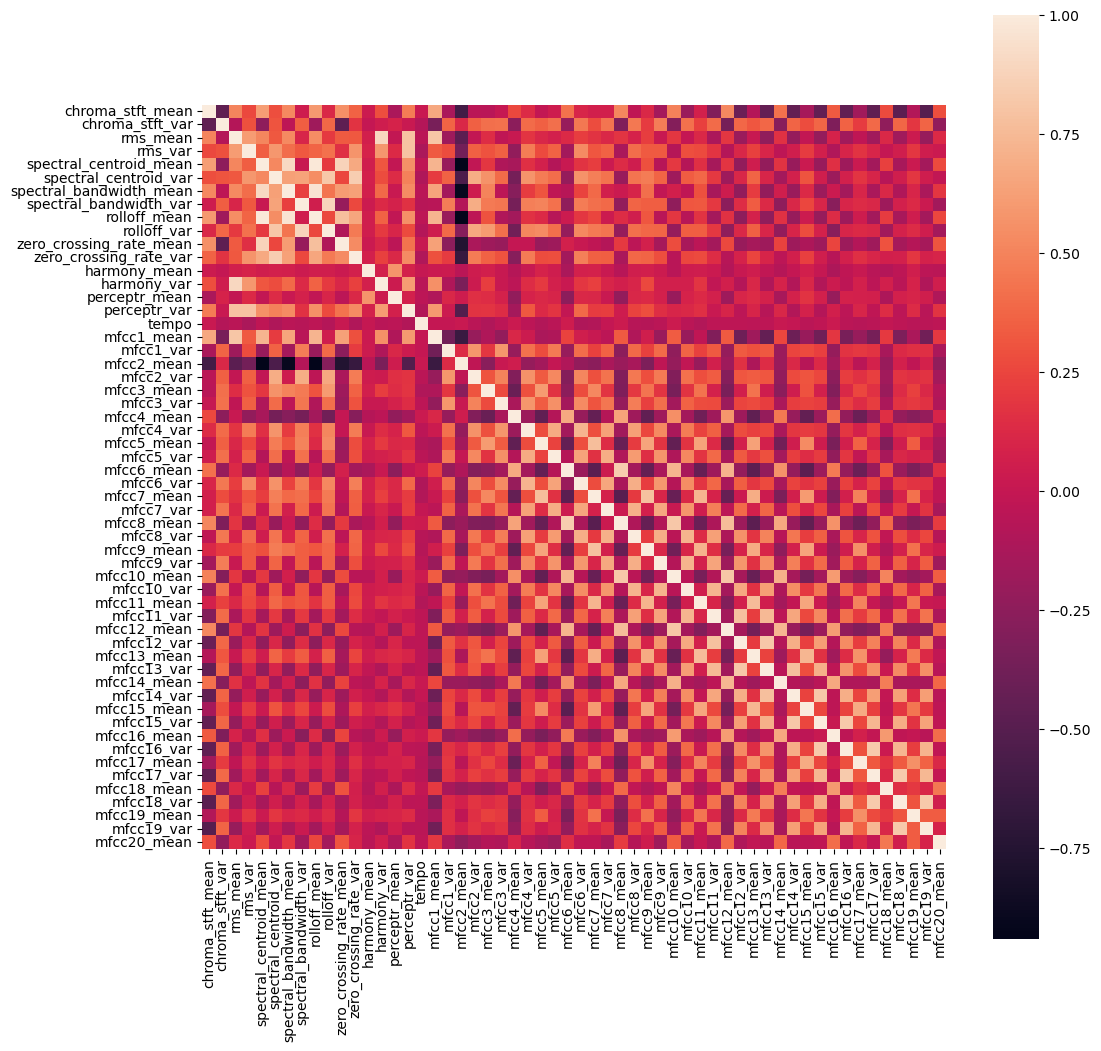

In [93]:
cor = df.iloc[:, 2:-2].corr()
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(cor, square = True, xticklabels=True, yticklabels=True) 
plt.show()

We can see that there are quite a few feature combinations with high correlations, notably in the upper left corner, for example between the rolloff mean and the spectral centroid mean, as well as the lower left corner between some of the mfcc values. Although this could be seen as a reason for dimensionality reduction by leaving out some of the highly correlated features, there is no telling whether some of these features could be important in combination due to the complexity and number of features. Thus, eventhough we have seen these correlations, we will still use all of the dimensions for training our models.

## 1. Data preparation

Because the dataset is already in a good condition for further analysis, we won't have much to do in terms of data preparation. First, we will encode the genre labels numerically.

In [94]:
random_state = 0
LabelEnc = LabelEncoder()
y = df['label']
y = pd.DataFrame(LabelEnc.fit_transform(y))
df['label_enc'] = y

Next, we will separate the dataset in labels and features and scale the features linearly to a scale between 0 and 1 using the MinMaxScaler.

In [95]:
scaler_mms = MinMaxScaler()

X = df.loc[:, 'chroma_stft_mean' : 'mfcc20_var']
X_scaled_array_mms = scaler_mms.fit_transform(X)

X_scaled_mms = pd.DataFrame(X_scaled_array_mms, columns=X.columns)

print(X)
print(X_scaled_mms)


     chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
0            0.350088         0.088757  0.130228  0.002827   
1            0.340914         0.094980  0.095948  0.002373   
2            0.363637         0.085275  0.175570  0.002746   
3            0.404785         0.093999  0.141093  0.006346   
4            0.308526         0.087841  0.091529  0.002303   
..                ...              ...       ...       ...   
995          0.352063         0.080487  0.079486  0.000345   
996          0.398687         0.075086  0.076458  0.000588   
997          0.432142         0.075268  0.081651  0.000322   
998          0.362485         0.091506  0.083860  0.001211   
999          0.358401         0.085884  0.054454  0.000336   

     spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
0               1784.165850          129774.064525              2002.449060   
1               1530.176679          375850.073649              2039.036516   
2               15

Now we separate the data we scaled into training and testing data, which already concludes the data preparation.

In [96]:
X_train_mms, X_test_mms, y_train_mms, y_test_mms = train_test_split(X_scaled_mms, y, test_size=0.2, random_state=0, stratify=y)

## 2. Model training 

Each model is trained and the quality of the classifier (accuracy) is displayed. 

### 2.1 Random Forests
Author: Spyridon S. 

In this section Random Forest as a classifier will be tested. 

When training random forests, there is no heavy hyperparameter tuning needed to get a good accuracy. The structure of the model is already decreasing bias and variance by injecting randomness on constructing the trees. By random feature selection and bagging the risk of overfitting is minimized, and by slightly tuning the hyperparameters, the underfitting risk is also minimized. Nevertheless, we will perform a soft hyperparameter tuning, as well as a heavy hyperparameter tuning. The aim is to see if it makes sense to preform a heavy hyperparameter tuning.

#### 2.1.1 Simple Hyperparameter tuning 
It is enough only to tune the number of trees in the ensemble "n_estimators" and the splitting criterion. All other hyperparameters will use the default values. 

In [97]:

rf = RandomForestClassifier(random_state=random_state, n_jobs=-1)
param_grid = {'n_estimators': np.array([ 100, 250, 500, 1000, 2000, 7000]), 
              'criterion':['gini','entropy', 'log_loss'],
              }
grid_search_rf_simple = GridSearchCV(rf, param_grid, n_jobs=-1, cv=2, scoring='accuracy', verbose=1, refit=True)
start = dt.datetime.now()
grid_search_rf_simple.fit(X_train_mms, y_train_mms.values.ravel()) # MinMaxScaler is not really needed for Random Forest, but we are using it to be consistent with other models
end = dt.datetime.now()
print(f"Training for MinMaxScaler data took {end - start}")
y_pred_rf_simple = grid_search_rf_simple.predict(X_test_mms)


Fitting 2 folds for each of 18 candidates, totalling 36 fits
Training for MinMaxScaler data took 0:00:20.930852


The GridSearch found out the best model, the results are: 

In [98]:
grid_search_rf_simple.score(X_test_mms, y_test_mms)
print("Best Score: %f" % grid_search_rf_simple.best_score_)
print("Optimal Hyperparameter Values: ", grid_search_rf_simple.best_params_)
print("Optimal Model: ", grid_search_rf_simple.best_estimator_)
accuracy_rf_simple = accuracy_score(y_test_mms, y_pred_rf_simple)
print(f"Accuracy: {accuracy_rf_simple}")

Best Score: 0.682500
Optimal Hyperparameter Values:  {'criterion': 'gini', 'n_estimators': 1000}
Optimal Model:  RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=0)
Accuracy: 0.76


So in ~20 seconds (on my machine), Gridsearch found a model with 76% accuracy. That's a really good result! 

#### 2.1.2 Heavy Hyperparameter tuning

But let's also try some heavy hyperparameter tuning to see what results can be achieved: (This takes some time.... ~20min.) 

In [99]:

rf_heavy = RandomForestClassifier(random_state=random_state, n_jobs=-1)
param_grid_rf_heavy = {'n_estimators': np.array([ 100, 250, 500, 1000, 2000, 7000]), 
              'criterion':['gini','entropy', 'log_loss'],
              'max_depth': np.array([3,5, 7,10, None]),
                'min_samples_split': np.array([2, 5, 10]),
                'min_samples_leaf': np.array([1, 2, 4]),
                'max_features': np.array(['sqrt', 'log2'])
              }
grid_search_rf_heavy = GridSearchCV(rf_heavy, param_grid_rf_heavy, n_jobs=-1, cv=2, scoring='accuracy', verbose=1, refit=True)
start = dt.datetime.now()
grid_search_rf_heavy.fit(X_train_mms, y_train_mms.values.ravel())
end = dt.datetime.now()
print(f"Training for MinMaxScaler data took {end - start}")
y_pred_heavy = grid_search_rf_heavy.predict(X_test_mms)

Fitting 2 folds for each of 1620 candidates, totalling 3240 fits
Training for MinMaxScaler data took 0:17:55.343814


Now that needed a lot of time. It took nearly 20 minutes to get the results. Hopefully the created model is better:

In [100]:
grid_search_rf_heavy.score(X_test_mms, y_test_mms)
print("Best Score: %f" % grid_search_rf_heavy.best_score_)
print("Optimal Hyperparameter Values: ", grid_search_rf_heavy.best_params_)
print("Optimal Model: ", grid_search_rf_heavy.best_estimator_)
print(f"Accuracy: {accuracy_score(y_test_mms, y_pred_heavy)}")

Best Score: 0.682500
Optimal Hyperparameter Values:  {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}
Optimal Model:  RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=0)
Accuracy: 0.76


The resulting model is exactly the same found with by soft tuning. All remaining parameters are the default parameters.

#### 2.1.3 Best Random Forest

We see that with heavy hyperparameter tuning, that needed more than 15 minutes, the resulting forest is not really giving much more performance. So our best Random Forest model is the following:

In [101]:
rf_simple_best = grid_search_rf_simple.best_estimator_
rf_simple_best 

RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=0)

In the following the feature importance of the best random forest can be seen:

Feature ranking with names:


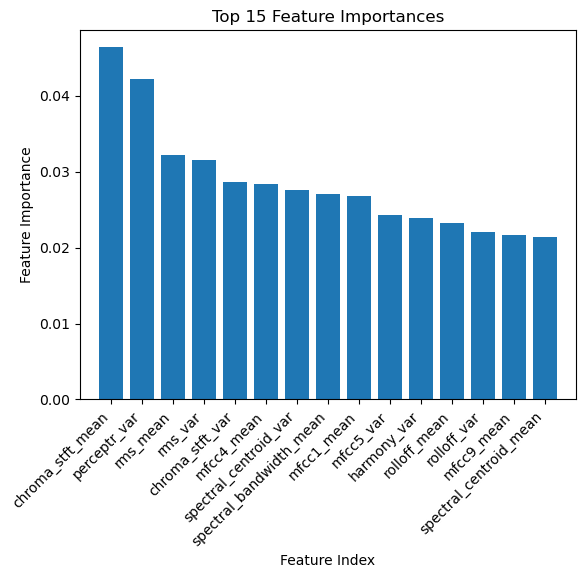

In [102]:
rf_simple_best = grid_search_rf_simple.best_estimator_

importances = rf_simple_best.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns


top_n = 15
top_indices = indices[:top_n]
top_importances = importances[top_indices]

top_feature_names = [feature_names[idx] for idx in top_indices]
print("Feature ranking with names:")


plt.figure()
plt.title(f"Top {top_n} Feature Importances")
plt.bar(range(top_n), top_importances, align="center")
plt.xticks(range(top_n), top_feature_names, rotation=45, ha='right')
plt.xlabel('Feature Index')
plt.ylabel('Feature Importance')
plt.xlim([-1, top_n])
plt.show()


### 2.2 Decision trees

Author: Jan W.

Now we will build single decision trees to see how big the difference is compared to the Random Forest model. Realistically, our expectations are not very high because the Random Forest model usually performs better than single trees.

First we will build a full tree and see how it performs. Since the tree is not pruned, we expect some overfitting.

In [103]:
cls = DecisionTreeClassifier(random_state=random_state)
full_tree = cls.fit(X_train_mms, y_train_mms)
pred = full_tree.predict(X_test_mms)
print('Test accuracy',accuracy_score(y_test_mms, pred))

Test accuracy 0.51


Although our expectations were not that high, an accuracy just over 50% is still pretty disappointing. Now lets see how a pruned tree performs instead.

First we will build a tree using post-pruning. Post-pruning is done using hyperparameter-tuning with GridsearchCV and will be tried out first since it showed the most promise in exercises during the lecture. For that, we will draw a graph in which we can see all of the regularization parameter values (effective alpha).

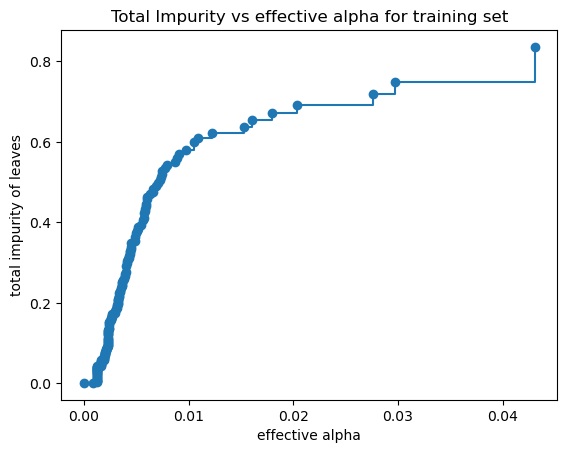

In [104]:
clf = DecisionTreeClassifier(random_state=random_state) 
path = clf.cost_complexity_pruning_path(X_train_mms, y_train_mms)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

plt.show()

Now we use GridSearchCV to tune the alpha parameter, determining the best of the above shown values by using cross validation. Then, we will use the best resulting tree to predict the labels corresponding to our test set and print the accuracy.

In [105]:
parameters = {'ccp_alpha':ccp_alphas[:-1].tolist()}
gs = GridSearchCV(DecisionTreeClassifier(random_state=random_state), parameters, cv=10, refit=True, n_jobs=-1)
gs.fit(X_train_mms,y_train_mms)
tree_best = gs.best_estimator_
pred = tree_best.predict(X_test_mms)
print('Accuracy', accuracy_score(y_test_mms, pred))

Accuracy 0.49


Although the hyperparameter tuning took more time than building the previous tree, the post-pruned tree performs worse than the un-pruned tree, which is surprising. We will visualize its rules in the following cells.

In [106]:
rules = export_text(tree_best, feature_names=X.columns)
print(rules)

|--- perceptr_var <= 0.00
|   |--- rolloff_var <= 0.19
|   |   |--- mfcc9_mean <= 0.28
|   |   |   |--- class: 5
|   |   |--- mfcc9_mean >  0.28
|   |   |   |--- perceptr_mean <= 0.56
|   |   |   |   |--- class: 1
|   |   |   |--- perceptr_mean >  0.56
|   |   |   |   |--- chroma_stft_mean <= 0.16
|   |   |   |   |   |--- class: 5
|   |   |   |   |--- chroma_stft_mean >  0.16
|   |   |   |   |   |--- class: 1
|   |--- rolloff_var >  0.19
|   |   |--- mfcc4_var <= 0.19
|   |   |   |--- class: 5
|   |   |--- mfcc4_var >  0.19
|   |   |   |--- class: 1
|--- perceptr_var >  0.00
|   |--- spectral_centroid_var <= 0.16
|   |   |--- chroma_stft_mean <= 0.52
|   |   |   |--- perceptr_var <= 0.02
|   |   |   |   |--- mfcc2_var <= 0.12
|   |   |   |   |   |--- mfcc3_mean <= 0.40
|   |   |   |   |   |   |--- rolloff_mean <= 0.26
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- rolloff_mean >  0.26
|   |   |   |   |   |   |   |--- class: 9
|   |   |   |   |   |--- mfcc3_mean 

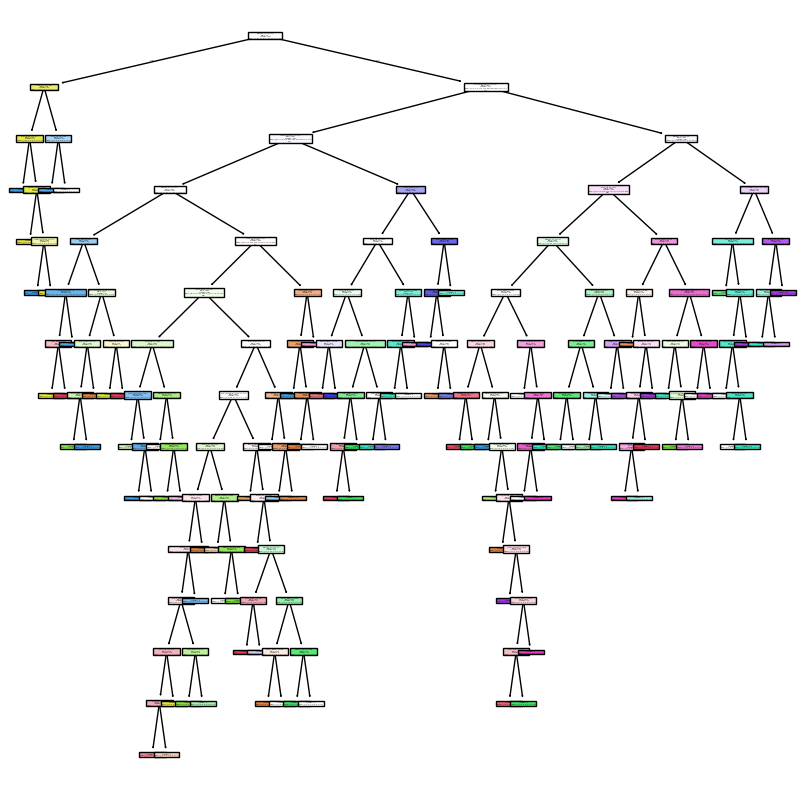

In [107]:
fig = plt.figure(figsize=(10,10))
text = tree.plot_tree(tree_best, 
                   feature_names=X.columns.to_list(), 
                   filled=True)

plt.show()

Additionally, we will list the top 15 features' importance.

Feature ranking with names:


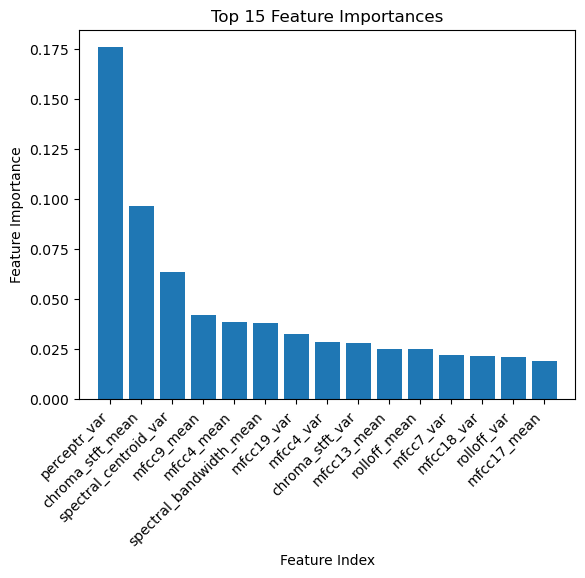

In [108]:
importances = tree_best.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns


top_n = 15
top_indices = indices[:top_n]
top_importances = importances[top_indices]

top_feature_names = [feature_names[idx] for idx in top_indices]
print("Feature ranking with names:")


plt.figure()
plt.title(f"Top {top_n} Feature Importances")
plt.bar(range(top_n), top_importances, align="center")
plt.xticks(range(top_n), top_feature_names, rotation=45, ha='right')
plt.xlabel('Feature Index')
plt.ylabel('Feature Importance')
plt.xlim([-1, top_n])
plt.show()

Now we will try pre-pruning with a lower maximum tree height to avoid overfitting and use a cross validation again to tune the parameters, which in this case are the maximum height and the type of purity measurement (gini or entropy). First we build the tree using GridSearchCV again.

In [109]:
cls = DecisionTreeClassifier(random_state=random_state)

params = {'max_depth':np.arange(3,15),
          'criterion':['gini','entropy']}
gs = GridSearchCV(cls, params, scoring='accuracy', cv=10, verbose=1, n_jobs=-1, refit=True)
gs.fit(X_train_mms, y_train_mms)
params_optimal = gs.best_params_

print("Best Score: %f" % gs.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal)

Fitting 10 folds for each of 24 candidates, totalling 240 fits
Best Score: 0.557500
Optimal Hyperparameter Values:  {'criterion': 'entropy', 'max_depth': 9}


We can already see that the depth of this tree is quite a lot smaller than the one we got from post-pruning, although the training score still doesn't look very promising. Also, we will note that the tuning went considerably faster than that of the post-pruned tree. Now let's look at the accuracy on the test set.

In [110]:
tree_best = gs.best_estimator_
pred = tree_best.predict(X_test_mms)
accuracy_dt = accuracy_score(y_test_mms, pred)
print('Test accuracy',accuracy_dt)

Test accuracy 0.53


The result we got on the test set is still not good at all, but at least we got over 50% this time, which makes this tree favorable compared to the post-pruning tree earlier. In the following cells we will again visualize the tree's rules and the features' importance.

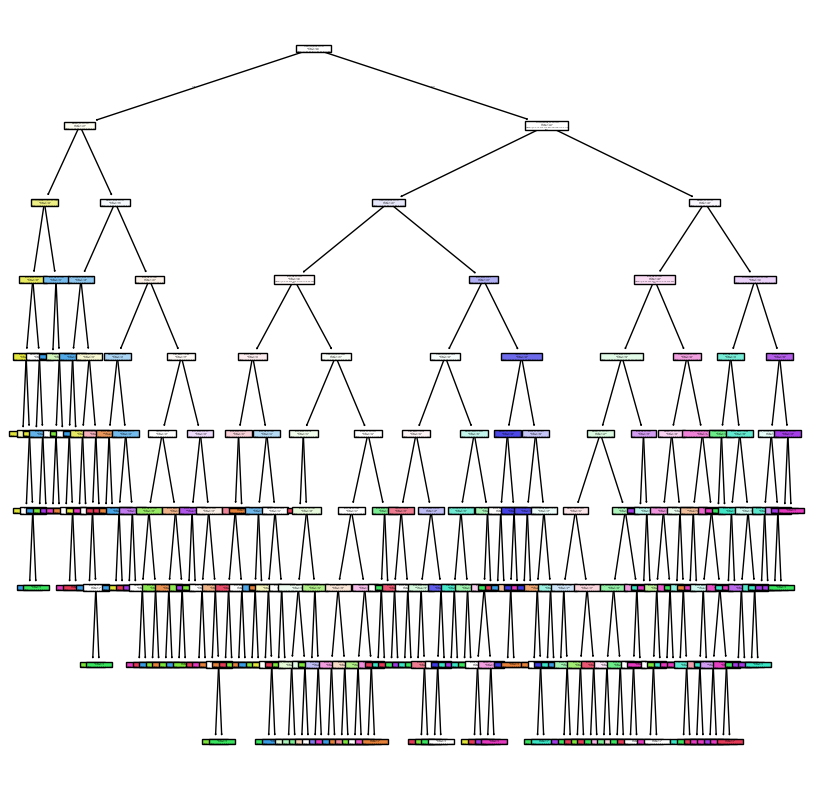

In [111]:
fig = plt.figure(figsize=(10,10))
text = tree.plot_tree(tree_best, 
                   feature_names=X.columns.to_list(), 
                   filled=True)

plt.show()

Feature ranking with names:


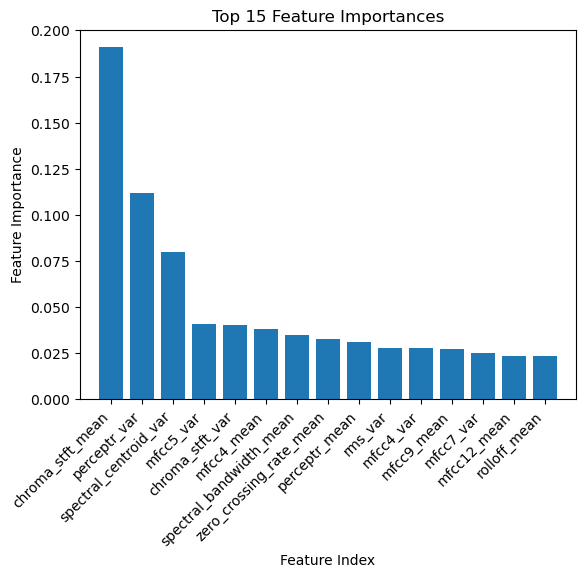

In [112]:
importances = tree_best.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns


top_n = 15
top_indices = indices[:top_n]
top_importances = importances[top_indices]

top_feature_names = [feature_names[idx] for idx in top_indices]
print("Feature ranking with names:")


plt.figure()
plt.title(f"Top {top_n} Feature Importances")
plt.bar(range(top_n), top_importances, align="center")
plt.xticks(range(top_n), top_feature_names, rotation=45, ha='right')
plt.xlabel('Feature Index')
plt.ylabel('Feature Importance')
plt.xlim([-1, top_n])
plt.show()

### 2.3 KNN

Author: Lisa K.

Now the music genres are classified with the **k-Nearest Neighbors** algorithm. To enhance model performance, it can be useful to tune the following three hyperparameters via cross validation:
* ***n_neighbors***  :  number of neighbors $k$
* ***weights***  :  weights assigned to the nearest neighbors, especially relevant in case of ties
  - 'uniform'  :  all neighbors have equal weights
  - 'distance'  :  neighbors closer to the target point have higher weights
* ***metric***  :  method for distance computation
  - 'euclidean'  :  Euclidean distance
  - 'manhatten'  :  Manhatten distance

The first step is to define the possible values for each of these parameters in a dictionary.

In [113]:
# Define parameter combinations for hyperparameter tuning via cross validation 
params = {'n_neighbors': np.arange(1,20),               # parameter 'k' 
              'weights': ['uniform', 'distance'],       # parameter 'weights'
              'metric' : ['euclidean','manhattan']}     # parameter 'metric'

Then hyperparameter tuning is performed with the help of *GridSearchCV*, using 10-fold cross validation and accuracy as evaluation measure. The model is trained on the training data which have been normalized with the *MinMaxScaler*. Since kNN relies on distance measures, feature scaling is a necessary pre-processing step in this case.

In [114]:

# Create KNN classifier
knn = KNeighborsClassifier()
# Use GridSearchCV to tune the chosen parameters
gs = GridSearchCV(knn, params, scoring='accuracy', cv=10, verbose=0, n_jobs=-1, refit=True)
# Train
gs.fit(X_train_mms, y_train_mms.values.ravel())    # Use training data scaled with MinMaxScaler

GridSearchCV(cv=10, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

As can be seen from the optimal parameter set, choosing $k=3$ nearest neighbors, distance-dependent weights and Manhattan distance turns out to be the best combination in this experiment. Yet, it must be noted that distance-related weights are also computed if there are no ties, which might lead to overfitting.

In [115]:
params_optimal = gs.best_params_

print("Best score: %f" % gs.best_score_)
print("Optimal hyperparameters: ", params_optimal)

Best score: 0.717500
Optimal hyperparameters:  {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}


Finally, this optimal classifier is taken to predict the music genres in the corresponding test set.

In [116]:
# Choose optimal classifier to predict
knn_optimal = gs.best_estimator_
y_pred_optimal = knn_optimal.predict(X_test_mms)

The evaluation shows that the tuned kNN model performs with an accuracy of 74% on these test data, which is an unexpectedly good result. 

In [117]:
# Accuracy for tuned KNN
accuracy_knn = accuracy_score(y_test_mms, y_pred_optimal)
print('Accuracy:', accuracy_knn)  

Accuracy: 0.74


### 2.4 Neural Networks - ANN

Authors: Adrian D. and Jan B.

#### Hyperparameter Tuning and Model Training

To get the best possible result for an Artificial Neural Network, we want to tune our hyperparameters (the hidden layer sizes, the batch size, the activation function and the learning rate) beforehand. Since our dataset has only 1000 entries, let's attempt to use an approach similar to the one given in material notebook no. 10.

In [118]:
params = {
    'hidden_layer_sizes': [(randint.rvs(2, 200), randint.rvs(2, 200))],
    'activation': ['tanh', 'relu', 'logistic'],
    'alpha': [0.0001, 0.001, 0.05],
    'learning_rate_init': uniform(0.001, 0.01),
    'batch_size': randint(16, 128),
    'learning_rate': ['constant', 'adaptive', 'invscaling']
}

To get the best possible tuning, we will test with a combination of hyperparameters.

In [119]:
mlp = MLPClassifier(solver='adam',
                   max_iter=2000,
                   random_state=random_state)

clf_mms = RandomizedSearchCV(mlp, params, n_jobs=-1, cv=10)

As we prepared the data with the `MinMaxScaler`, let's use them.

In [120]:
start = dt.datetime.now()
clf_mms.fit(X_train_mms, y_train_mms.values.ravel())
end = dt.datetime.now()
print(f"Training for MinMaxScaler data took {end - start}")


clf_mms

Training for MinMaxScaler data took 0:00:20.498414


RandomizedSearchCV(cv=10,
                   estimator=MLPClassifier(max_iter=2000, random_state=0),
                   n_jobs=-1,
                   param_distributions={'activation': ['tanh', 'relu',
                                                       'logistic'],
                                        'alpha': [0.0001, 0.001, 0.05],
                                        'batch_size': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x33737df50>,
                                        'hidden_layer_sizes': [(151, 164)],
                                        'learning_rate': ['constant',
                                                          'adaptive',
                                                          'invscaling'],
                                        'learning_rate_init': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x16dd25750>})

In [121]:
pred_train_mms = clf_mms.predict(X_train_mms)
print('Train accuracy with MinMaxScaler:', accuracy_score(pred_train_mms, y_train_mms))
pred_test_mms = clf_mms.predict(X_test_mms)
print('Test accuracy with MinMaxScaler:', accuracy_score(pred_test_mms, y_test_mms))

Train accuracy with MinMaxScaler: 0.99875
Test accuracy with MinMaxScaler: 0.745


Of course, as we used `randint` to randomize our hyperparameters for the number of neurons of the two hidden layers as well as the batch size, the accuracy will vary slightly each time the notebook is run. After a few tests, the best results were reached with the following parameters:  

In [122]:
ann_best_params = {'activation': 'relu',
 'alpha': 0.001,
 'batch_size': 63,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (70, 170),
 'learning_rate': 'invscaling',
 'learning_rate_init': 0.0014079058662580348,
 'max_fun': 15000,
 'max_iter': 2000,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 0,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

ann_best = MLPClassifier(**ann_best_params)
ann_best.fit(X_train_mms, y_train_mms.values.ravel())
y_pred_ann = ann_best.predict(X_test_mms)
accuracy_ann = accuracy_score(y_test_mms, y_pred_ann)
print('Accuracy:', accuracy_ann)

Accuracy: 0.77


As we can see, the data scaled with the `MinMaxScaler` yields the best result with a test accuracy of around 77%. We also tested an ANN with a third hidden layer, which, however, did not improve the test accuracy for `MinMaxScaler` data.

## 3. Comparing Models 

In this section the resulting best models will be compared. 

As a first step, we create an array with the best models and their names: 

In [123]:
models = [knn_optimal, tree_best, rf_simple_best, ann_best]
model_names = ['KNN', 'Decision Tree', 'Random Forest', 'ANN']

### 3.1 Accuracy

Each Accuracy of the models will be shown here:

In [124]:
for model, name in zip(models, model_names): 
    y_pred = model.predict(X_test_mms)
    accuracy = accuracy_score(y_test_mms, y_pred)
    print(f"Accuracy of {name}: {accuracy}")

Accuracy of KNN: 0.74
Accuracy of Decision Tree: 0.53
Accuracy of Random Forest: 0.76
Accuracy of ANN: 0.77


It can be seen that ANNs have the best accuracy, followed by RFs and KNN. Decision Trees performed poorly here.

### 3.2 F1-Score

The F1-Score of all models will be calculated. 
The F1-Scores can be interpreted as follows: 

![image](https://images.prismic.io/encord/3b4efcda-c027-46d6-b4e1-02cad9ff5f48_image18.png?auto=compress,format)

In [125]:
# F1 score of each model
for model, name in zip(models, model_names): 
    y_pred = model.predict(X_test_mms)
    f1 = f1_score(y_test_mms, y_pred, average='weighted')
    print(f"F1 Score of {name}: {f1}")

F1 Score of KNN: 0.7430698080583664
F1 Score of Decision Tree: 0.5320782232358159
F1 Score of Random Forest: 0.7605592636233927
F1 Score of ANN: 0.7723010925648475


So according to the table, KNN, RF and ANN had a good result. The result of Decision Trees was OK.

### 3.3 ROC, AUC Curve

A good comparison also can be made using the ROC-Curve and the AUC of each model. Due to the fact that ROC is designed for binary classifiers and our dataset contains 10 classes, we could create a ROC curve for each tuple of classes. But we decided to use a technique that averages the ROC-curves of all classes so that one ROC curve can be calculated for a multi-class classifier.

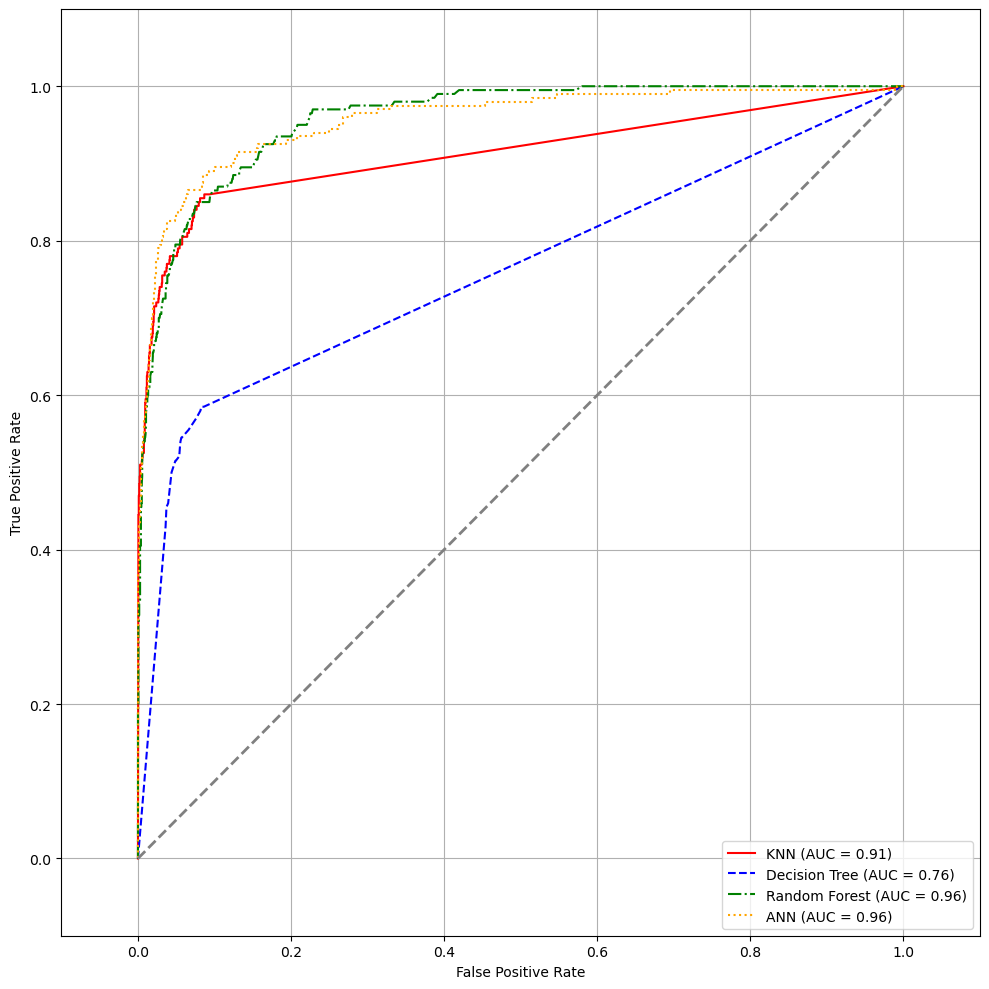

In [126]:
# We need to binarize the labels for the ROC curve
y_test_bin = label_binarize(y_test_mms, classes=np.unique(y))
y_train_bin = label_binarize(y_train_mms, classes=np.unique(y))
n_classes = y_test_bin.shape[1]

plt.figure(figsize=(10, 10))
colors = ['red', 'blue', 'green', 'orange']
linestyles = ['-', '--', '-.', ':']
classifiers = models
labels = model_names

for clf, label, clr, ls in zip(classifiers, labels, colors, linestyles):
    classifier = OneVsRestClassifier(clf, n_jobs=-1)
    y_score = classifier.fit(X_train_mms, y_train_bin).predict_proba(X_test_mms)    
    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=clr, linestyle=ls, label='%s (AUC = %0.2f)' % (label, roc_auc))


plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2)

plt.legend(loc='lower right')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.tight_layout()
plt.show()

As can be seen from the ROC-graph, Random Forests and Artificial Neural Networks have the best AUC. KNN is on third place and Decision Trees are last.

### 3.4 Summary: Comparison of models

In [127]:
model_entries = []
model_list = [
    ("KNN", knn_optimal),
    ("Decision Tree", tree_best),
    ("Random Forest", rf_simple_best),
    ("MLP", ann_best)
]

for model_name, model_obj in model_list:
    y_pred = model_obj.predict(X_test_mms)
    acc = accuracy_score(y_test_mms, y_pred)
    f1 = f1_score(y_test_mms, y_pred, average='weighted')
    classifier_ovr = OneVsRestClassifier(model_obj, n_jobs=-1)
    y_score = classifier_ovr.fit(X_train_mms, y_train_bin).predict_proba(X_test_mms)
    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc_val = auc(fpr, tpr)
    model_entries.append({
        "Model": model_name,
        "Accuracy": acc,
        "F1 Score (weighted)": f1,
        "ROC AUC (micro)": roc_auc_val
    })

comparison_df = pd.DataFrame(model_entries)
comparison_df.style.format(precision=3)

,Model,Accuracy,F1 Score (weighted),ROC AUC (micro)
0,KNN,0.740,0.743,0.913
1,Decision Tree,0.530,0.532,0.759
2,Random Forest,0.760,0.761,0.958
3,MLP,0.770,0.772,0.956


## 4. Test own songs

Author: Spyridon S.

To test our own songs, we need to extract the features of our song. To do this we are going to use librosa, a library for sound analysis. If not installed, please install it using ```pip install librosa```.

In [128]:
import librosa
# pip install librosa , if you haven't already
import warnings
warnings.filterwarnings('ignore')
import os

For the feature extraction we use code from kaggle as a reference. (https://www.kaggle.com/code/esabellechen/gtzan-features-extract)

The code is analyzing the sound files and extracting the needed features. Due to license restrictions, we will not upload the tested sound files. But the sound files were mostly taken from these websites: 
https://www.minimalstudio.de/download-wav/
https://pixabay.com/music/search/wav/

In [132]:

# To test it, proceed as follows:
# 1. Create a folder called "songs" in the same directory as this script
# 2. Create subfolders in "songs" for each genre
# 3. Add songs to the respective genre folders
# 4. Run the script
# 5. The extracted features will be stored in the data_df variable

# due to license restrictions, we cannot provide the songs used in the example


data_df=[]
songs_path = "songs"
genres = os.listdir(songs_path)
for g in genres:
    print(f"Processing {g}...")
    genre_path = os.path.join(songs_path, g)
    for file_name in os.listdir(genre_path):
        song_path = os.path.join(genre_path, file_name)
        try:
            Y, sr = librosa.load(song_path, mono=True )
            chroma_stft = librosa.feature.chroma_stft(y=Y, sr=sr)
            rms = librosa.feature.rms(y=Y)
            spec_cent = librosa.feature.spectral_centroid(y=Y, sr=sr)
            spec_bw = librosa.feature.spectral_bandwidth(y=Y, sr=sr)
            rolloff = librosa.feature.spectral_rolloff(y=Y, sr=sr)
            zcr = librosa.feature.zero_crossing_rate(Y)
            harmony, perceptr = librosa.effects.harmonic(Y), librosa.effects.percussive(Y)
            tempo, _ = librosa.beat.beat_track(y=Y, sr=sr)
            mfcc = librosa.feature.mfcc(y=Y, sr=sr, n_mfcc=20)

            features = [
                f"{file_name}", len(Y),
                np.mean(chroma_stft), np.var(chroma_stft),
                np.mean(rms), np.var(rms),
                np.mean(spec_cent), np.var(spec_cent),
                np.mean(spec_bw), np.var(spec_bw),
                np.mean(rolloff), np.var(rolloff),
                np.mean(zcr), np.var(zcr),
                np.mean(harmony), np.var(harmony),
                np.mean(perceptr), np.var(perceptr),
                float(tempo) 
                ]

            for coeff in mfcc:
                features.append(np.mean(coeff))
                features.append(np.var(coeff))
            
            features.append(g)

            data_df.append(features)
        except Exception as e:
            print(f"Error processing {song_path}: {e}")
            continue


Processing pop...
Processing metal...
Processing blues...
Processing classical...
Processing rock...


Now that the features are extracted, let's put them on a dataframe and extract them to a csv.

In [133]:
columns=['filename', 'length',
         'chroma_stft_mean', 'chroma_stft_var',
         'rms_mean', 'rms_var',
         'spectral_centroid_mean', 'spectral_centroid_var',
         'spectral_bandwidth_mean', 'spectral_bandwidth_var',
         'rolloff_mean', 'rolloff_var',
         'zero_crossing_rate_mean','zero_crossing_rate_var',
         'harmony_mean', 'harmony_var',
         'perceptr_mean', 'perceptr_var',
         'tempo'] + \
         [f'mfcc{i+1}_{stat}' for i in range(20) for stat in ['mean', 'var']] + ['label']

         
print(len(columns))
df_own = pd.DataFrame(data_df, columns=columns)
feature_columns = df_own.columns.difference(['filename', 'label', 'length'])

df_own_scaled = df_own.copy()
df_own_scaled[feature_columns] = scaler_mms.transform(df_own.loc[:, 'chroma_stft_mean' : 'mfcc20_var'])

df_own.to_csv('genres30_features.csv',index=False)
df_own_scaled.to_csv('genres30_features_scaled.csv',index=False)

df_own_scaled.head(5)


60


,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,tidal-wave-2wav-remix-by-aap-ft-leo-valentine-...,3805632,0.618427,0.713174,0.181059,0.740896,0.187551,0.571391,0.142811,0.531968,...,0.735598,0.193335,0.380597,0.336456,0.752585,0.232528,0.466468,0.141418,0.601111,pop
1,rumo-ao-sol-13162.mp3,1401408,0.137766,0.633529,0.524790,0.640575,0.273132,0.496485,0.158820,0.570744,...,0.582780,0.302467,0.345850,0.063925,0.671201,0.030701,0.653800,0.092958,0.582123,pop
2,808 pop.wav,4184103,0.383921,0.759103,0.050463,0.518073,0.050868,0.646449,0.060689,0.455449,...,0.741329,0.257569,0.450709,0.439265,0.845763,0.091357,0.455050,0.066745,0.677625,pop
3,empires-fall-thrash-metal-instrumental-284184.mp3,4524660,0.465514,0.590079,0.146013,0.627287,0.068694,0.512809,0.088605,0.469155,...,0.782272,0.127295,0.244982,0.075730,0.505961,0.184464,0.592794,0.212439,0.539382,metal
4,hard-rock-metal-music-248899.mp3,3633408,0.643238,0.396217,0.024953,0.534307,0.013124,0.451498,0.012294,0.471225,...,0.877723,0.146088,0.633776,0.563129,0.476319,0.121804,0.546622,0.060567,0.414854,metal


Our classifiers will predict the genres on these songs. 

In [134]:

print(f"True labels: \n{df_own_scaled[['label' ,'filename']]}")

print("predicted labels: ")
print("Random Forest: ")
predicted_labels_rf = LabelEnc.inverse_transform(rf_simple_best.predict(df_own_scaled.loc[:, 'chroma_stft_mean':'mfcc20_var']))
for i in range(len(predicted_labels_rf)):
    print(f"datapoint {i} -> True value: {df_own_scaled['label'][i]};  \t \t Prediction: {predicted_labels_rf[i]}")
print("\nKNN: ")
predicted_labels_knn = LabelEnc.inverse_transform(knn_optimal.predict(df_own_scaled.loc[:, 'chroma_stft_mean':'mfcc20_var']))
for i in range(len(predicted_labels_knn)):
    print(f"datapoint {i} -> True value: {df_own_scaled['label'][i]};  \t \t Prediction: {predicted_labels_knn[i]}")
print("\nDecision Tree: ")
predicted_labels_dt = LabelEnc.inverse_transform(tree_best.predict(df_own_scaled.loc[:, 'chroma_stft_mean':'mfcc20_var']))
for i in range(len(predicted_labels_dt)):
    print(f"datapoint {i} -> True value: {df_own_scaled['label'][i]};  \t \t Prediction: {predicted_labels_dt[i]}")
print("\nANN: ")
predicted_labels_ann = LabelEnc.inverse_transform(ann_best.predict(df_own_scaled.loc[:, 'chroma_stft_mean':'mfcc20_var']))
for i in range(len(predicted_labels_ann)):
    print(f"datapoint {i} -> True value: {df_own_scaled['label'][i]};  \t \t Prediction: {predicted_labels_ann[i]}")



True labels: 
        label                                           filename
0         pop  tidal-wave-2wav-remix-by-aap-ft-leo-valentine-...
1         pop                              rumo-ao-sol-13162.mp3
2         pop                                        808 pop.wav
3       metal  empires-fall-thrash-metal-instrumental-284184.mp3
4       metal                   hard-rock-metal-music-248899.mp3
5       blues                                corporate blues.wav
6       blues                                   berlin blues.wav
7       blues                                   blues lounge.wav
8   classical                                     blue piano.wav
9   classical                              bittersweet piano.wav
10  classical                                excited piano 1.wav
11       rock                                       808 rock.wav
12       rock                                     blast rock.wav
13       rock                           alright now rock mix.wav
predicted l

A lot of misclassifications...  
One reason for that could be that the songs have not the same length as the training data. The varying lengths might distort the feature values. Another problem is that the classes might be too coarse grained. E.g. Rock music spans several decades and has changed over time. 

## 5. Summary and Conclusion


### 5.1 Summary
#### 5.1.1 Data Preparation and Scaling  
    
The dataset contains no null values. Also, all data is numerical, so no encoding is needed. Only the label was encoded, and the features were scaled using MinMaxScaler. 

#### 5.1.2 Model Training and Hyperparameter Tuning  
Each Model was trained on the same training dataset. On all models, hyperparameters were tuned so that better results can be achieved. For each model a small summary can be found in the following:
- Random Forest (RF)  
    - Used GridSearchCV for hyperparameter tuning, experimenting with different numbers of estimators and other parameters. 
    - The best model (rf_simple_best) was selected based on cross-validation accuracy.  
    - Features' importance were visualized to understand which input variables contributed most.
    - Also compared results of heavy/soft-hyperparameter-tuning and seen that soft-hyperparameter tuning resulted to better accuracy than heavy-hyperparameter tuning.   

- Decision Tree (DT)  
    - Demonstrated two techniques: post-pruning (via cost-complexity parameter ccp_alpha) and pre-pruning (via restricting max_depth).  
    - Used GridSearchCV to optimize parameters such as ccp_alpha, max_depth, and splitting criteria (“gini” vs. “entropy”).  
    - Visualized the resulting decision trees and extracted a text representation of its rules.  

- k-Nearest Neighbors (kNN)  
    - Tuned k (number of neighbors), weights (uniform or distance), and distance metric (Euclidean or Manhattan).  
    - After 10-fold cross validation, the best combination of hyperparameters was chosen, and predictions were made on the test set.  

- Artificial Neural Network (ANN, MLPClassifier)  
    - Used RandomizedSearchCV to explore hidden layer sizes, activation functions, batch size, and learning rate.  
    - Final chosen ANN model reached around 77% test accuracy.  

#### 5.1.3 Model Evaluation and Comparison  
The four main classifiers (KNN, Decision Tree, Random Forest, ANN) were compared on the test set and metrics included accuracy, F1 score (weighted), and ROC-AUC (averaged for multi-class) were compared. A summary table was produced showing the performance of each best model.  

#### 5.1.4 Experiment on additional songs
In our experiments we found out that all the models lack in performance when classifying the additional songs. The classifiers that had the most correct classifications were KNN and RF model with 2/14. ANN had 1/14 correct classifications and Decision trees had nothing correct. 



### 5.2 Conclusion  
Each of the four classifiers (KNN, Decision Tree, Random Forest, ANN) offered different trade-offs. It could be seen that Decision Trees seem to perform very poorly on this task, even with pruning. Random Forest and ANN showed strong performance (accuracy around 77%), with kNN close behind. So for music classification, Random Forests, Artificial Neural Networks and K-Nearest-Neighbors can be used, but nearly $\frac{1}{4}$ of the predictions theoretically could be false. But in our practical example we can see that the accuracy was really poor. 

## 6. References 

- Machine Learning Lectures and Notebooks
- https://scikit-learn.org/1.5/modules/generated/sklearn.ensemble.RandomForestClassifier.html
- https://scikit-learn.org/1.5/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier
- https://scikit-learn.org/1.5/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
- https://scikit-learn.org/1.5/modules/generated/sklearn.model_selection.RandomizedSearchCV.html
- https://scikit-learn.org/1.5/modules/generated/sklearn.model_selection.GridSearchCV.html
- https://scikit-learn.org/1.5/modules/generated/sklearn.preprocessing.MinMaxScaler.html
- https://machinelearningmastery.com/one-vs-rest-and-one-vs-one-for-multi-class-classification/
- https://scikit-learn.org/dev/modules/generated/sklearn.tree.DecisionTreeClassifier.html
- https://encord.com/blog/f1-score-in-machine-learning/#:~:text=Typically%2C%20an%20F1%20score%20%3E%200.9,to%20have%20a%20poor%20performance.
- https://www.minimalstudio.de/download-wav/
- https://pixabay.com/music/search/wav/
- https://librosa.org/doc/latest/feature.html#module-librosa.feature
- http://recherche.ircam.fr/anasyn/peeters/ARTICLES/Peeters_2003_cuidadoaudiofeatures.pdf